# Trabalho prático: teste vocacional na área de dados

O State of Data Brazil 2022 é um estudo abrangente sobre o mercado de trabalho brasileiro na área de dados, conduzido pela comunidade Data Hackers e a consultoria Bain & Company. A pesquisa foi realizada entre outubro e novembro de 2022, com 4271 respondentes, mapeando perfis demográficos, formação,
remuneração, desafios profissionais e o impacto do trabalho remoto. O dataset original era composto por 4271 instâncias e 353 atributos.

Após seleção e renomeação de alguns atributos, o dataset foi reduzido para 14 atributos listados na tabela abaixo:

In [23]:
#Instalando as bibliotecas necessárias
import pandas as pd
import altair as alt
import numpy as np
from kmodes.kmodes import KModes

In [24]:
df = pd.read_excel('data/sods.xlsx')

In [25]:
df.shape

(4271, 13)

In [26]:
df.head(5)

,idade,genero,etnia,pcd,vive_no_brasil,estado_moradia,nivel_ensino,formacao,tempo_experiencia_dados,linguagens_preferidas,bancos_de_dados,cloud_preferida,cargo
0,39.0,Masculino,Parda,Não,True,Distrito Federal (DF),Pós-graduação,Computação / Engenharia de Software / Sistemas...,de 1 a 2 anos,R,"PostgreSQL, Oracle, MySQL, SQL SERVER",Amazon Web Services (AWS),DBA/Administrador de Banco de Dados
1,32.0,Masculino,Parda,Não,True,Pará (PA),Graduação/Bacharelado,Outras Engenharias,de 3 a 4 anos,NaN,NaN,NaN,NaN
2,53.0,Masculino,Branca,Não,True,Distrito Federal (DF),Pós-graduação,Computação / Engenharia de Software / Sistemas...,de 3 a 4 anos,Python,"PostgreSQL, MySQL, Oracle, DB2",Amazon Web Services (AWS),Desenvolvedor/ Engenheiro de Software/ Analist...
3,27.0,Masculino,Branca,Não,True,Minas Gerais (MG),Doutorado ou Phd,Estatística/ Matemática / Matemática Computaci...,de 4 a 6 anos,Python,Google BigQuery,Não sei opinar,Cientista de Dados/Data Scientist
4,46.0,Feminino,Branca,Não,True,Pará (PA),Pós-graduação,Computação / Engenharia de Software / Sistemas...,Não tenho experiência na área de dados,Python,Microsoft Access,Amazon Web Services (AWS),Desenvolvedor/ Engenheiro de Software/ Analist...


In [27]:
df.columns

Index(['idade', 'genero', 'etnia', 'pcd', 'vive_no_brasil', 'estado_moradia',
       'nivel_ensino', 'formacao', 'tempo_experiencia_dados',
       'linguagens_preferidas', 'bancos_de_dados', 'cloud_preferida', 'cargo'],
      dtype='object')

### Seleção
Inicialmente iremos remover as colunas que atrapalham a decisão ética do dataframe. Removendo colunas como gênero, etnia, pcd. Ou seja, categorias mais evidentes. Para prevenirmos problemas como o relatado nas seguintes notícias:

https://epocanegocios.globo.com/Empresa/noticia/2018/10/amazon-desiste-de-ferramenta-secreta-de-recrutamento-que-mostrou-vies-contra-mulheres.html

ou

https://www.jusbrasil.com.br/artigos/sistema-de-inteligencia-artificial-nos-eua-preve-o-indice-de-reincidencia-dos-acusados/758855745

In [28]:
#verificando se os valores correspondem à colunas
df['genero'].value_counts()

genero
Masculino               3194
Feminino                1056
Prefiro não informar      12
Name: count, dtype: int64

In [29]:
df['pcd'].value_counts()

pcd
Não                     4198
Sim                       54
Prefiro não informar      19
Name: count, dtype: int64

In [30]:
df['etnia'].value_counts()

etnia
Branca                  2744
Parda                   1054
Preta                    291
Amarela                  128
Prefiro não informar      26
Outra                     17
Indígena                  11
Name: count, dtype: int64

In [31]:
#como estamos fazendo uma alteração no dataset, é uma boa prática criar uma nova variável de manipulação, para caso queiramos utilizar os valores anteriores
df_etico = df.drop(columns=['etnia', 'genero', 'pcd','vive_no_brasil', 'estado_moradia'])
df_etico.columns

Index(['idade', 'nivel_ensino', 'formacao', 'tempo_experiencia_dados',
       'linguagens_preferidas', 'bancos_de_dados', 'cloud_preferida', 'cargo'],
      dtype='object')

In [32]:
#conhecendo o restante da base de dados
#Verificamos que existem muitas colunas com valores object, o que não nos dá muita informação sobre o que encontrar nessas colunas,
#iremos realizar o tratamento desses dados posteriormente.
df_etico.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4271 entries, 0 to 4270
Data columns (total 8 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   idade                    4197 non-null   float64
 1   nivel_ensino             4271 non-null   object 
 2   formacao                 4149 non-null   object 
 3   tempo_experiencia_dados  3694 non-null   object 
 4   linguagens_preferidas    2979 non-null   object 
 5   bancos_de_dados          2978 non-null   object 
 6   cloud_preferida          2981 non-null   object 
 7   cargo                    2981 non-null   object 
dtypes: float64(1), object(7)
memory usage: 267.1+ KB


### Fazendo o tratamento da coluna Idade


In [33]:
df_etico_2 = df_etico.copy()

In [34]:
#Aqui verificamos que a maior idade é de 54 anos, a menor de 18 (não existe nenhum menor de idade trabalhando, ufa!) e a média é 31.
#Idade "pode" ser um fator importante para a nossa predição. Tendo em mente que maturidade pode estar relacionado com responsabilidade.
df_etico_2['idade'].describe()

count    4197.000000
mean       31.169168
std         6.902803
min        18.000000
25%        26.000000
50%        30.000000
75%        35.000000
max        54.000000
Name: idade, dtype: float64

In [35]:
#Verifica-se que existem dados faltantes aqui, iremos tratar isso posteriormente.
df_etico_2['idade'].isna().sum()

np.int64(74)

In [36]:
#Converter para inteiro apenas os valores não nulos, mantendo o resto como está
df_etico_2['idade'] = df_etico_2['idade'].apply(lambda x: int(x) if pd.notnull(x) and x.is_integer() else x)

In [37]:
#Contar a frequência de cada valor na coluna idade do DataFrame df_etico_2 e organiza o resultado em um novo DataFrame df_idade_count
idade_count = df_etico_2['idade'].value_counts()
df_idade_count = idade_count.reset_index()

In [38]:
df_idade_count.columns

Index(['idade', 'count'], dtype='object')

In [39]:
alt.Chart(df_idade_count).mark_bar().encode(
    x='idade',
    y='count'
)

alt.Chart(...)

In [40]:
df_idade_count.describe()

,idade,count
count,37.000000,37.000000
mean,36.000000,113.432432
std,10.824355,96.726286
min,18.000000,10.000000
25%,27.000000,32.000000
50%,36.000000,78.000000
75%,45.000000,189.000000
max,54.000000,299.000000


### Fazendo o tratamento da coluna nivel_ensino e formacao



In [41]:
df_etico_3 = df_etico_2.copy()

In [42]:
df_etico_3['nivel_ensino'].value_counts()

nivel_ensino
Graduação/Bacharelado         1510
Pós-graduação                 1314
Estudante de Graduação         613
Mestrado                       521
Doutorado ou Phd               191
Não tenho graduação formal     110
Prefiro não informar            12
Name: count, dtype: int64

In [43]:
#Não existem valores nulos aqui.
df_etico_3['nivel_ensino'].isna().sum()

np.int64(0)

In [44]:
#Existem valores nulos aqui.
df_etico_3['formacao'].isna().sum()

np.int64(122)

In [45]:
df_etico_3['formacao'].value_counts()

formacao
Computação / Engenharia de Software / Sistemas de Informação/ TI          1543
Outras Engenharias                                                         941
Economia/ Administração / Contabilidade / Finanças/ Negócios               641
Estatística/ Matemática / Matemática Computacional/ Ciências Atuariais     405
Outra opção                                                                200
Marketing / Publicidade / Comunicação / Jornalismo                         122
Química / Física                                                           112
Ciências Biológicas/ Farmácia/ Medicina/ Área da Saúde                     111
Ciências Sociais                                                            74
Name: count, dtype: int64

In [46]:
#Formatando os valores para string
df_etico_3['formacao'].apply(type).value_counts()

formacao
<class 'str'>      4149
<class 'float'>     122
Name: count, dtype: int64

In [47]:
#Formatando os valores para string
df_etico_3['nivel_ensino'] = df_etico_3['nivel_ensino'].astype(str)
df_etico_3['nivel_ensino'].apply(type).value_counts()

nivel_ensino
<class 'str'>    4271
Name: count, dtype: int64

In [48]:
df_nivel_ensino_count = df_etico_3['nivel_ensino'].value_counts().reset_index()
df_nivel_ensino_count.columns

Index(['nivel_ensino', 'count'], dtype='object')

In [49]:
alt.Chart(df_nivel_ensino_count).mark_bar().encode(
    x='nivel_ensino',
    y='count'
)

alt.Chart(...)

In [50]:
df_etico_3['formacao'] = df_etico_3['formacao'].replace('Outra opção', 'Outra formação')
df_formacao_count = df_etico_3['formacao'].value_counts().reset_index()
df_formacao_count.columns

Index(['formacao', 'count'], dtype='object')

In [51]:
alt.Chart(df_formacao_count).mark_bar().encode(
    x='formacao',
    y='count'
)

alt.Chart(...)

### Fazendo o tratamento da coluna linguagens_preferidas

In [52]:
df_etico_4 = df_etico_3.copy()

In [53]:
df_etico_4['linguagens_preferidas'].isna().sum()

np.int64(1292)

In [54]:
df_etico_4['linguagens_preferidas'].value_counts()

linguagens_preferidas
Python                              2581
R                                    248
Scala                                 35
SQL                                   28
C/C++/C#                              25
Julia                                 17
Sql                                    8
Rust                                   3
Elixir                                 3
sql                                    2
Go                                     2
PySpark                                2
Excel                                  2
NÃO SEI                                1
Clojure                                1
M Language                             1
xlsx                                   1
M                                      1
Spark                                  1
Aql                                    1
Não sei                                1
VBA                                    1
Dax                                    1
Não utilizo                        

In [55]:
df_linguagens_count = df_etico_4['linguagens_preferidas'].value_counts().reset_index()
df_linguagens_count.columns

Index(['linguagens_preferidas', 'count'], dtype='object')

In [56]:
alt.Chart(df_linguagens_count).mark_bar().encode(
    x='linguagens_preferidas',
    y='count'
)

alt.Chart(...)

In [57]:
df_etico_4['linguagens_preferidas'] = df_etico_4['linguagens_preferidas'].str.upper()

In [58]:
df_etico_4['linguagens_preferidas'] = df_etico_4['linguagens_preferidas'].replace(['SQL POSTEGRES','EXCEL','AQL','SQL','KQL','XLSX','VBA'],'QUERY LANGUAGES')
df_etico_4['linguagens_preferidas'] = df_etico_4['linguagens_preferidas'].replace(['NÃO SEI','NENHUM','NENHUMA','NAO ATUO COM PROGRAMAÇÃO','NÃO USO','NÃO UTILIZO'],'NÃO INFORMADO')
df_etico_4['linguagens_preferidas'] = df_etico_4['linguagens_preferidas'].replace(['SAS','PYSPARK','SPARK','M','DAX','SOFTWARES ESTATÍSTICOS COMO SPSS'],'FRAMEWORKS PARA PROCESSAMENTO DE DADOS')
df_etico_4['linguagens_preferidas'] = df_etico_4['linguagens_preferidas'].replace('CLOJURE','JAVA')
df_etico_4['linguagens_preferidas'].value_counts()

linguagens_preferidas
PYTHON                                    2581
R                                          248
QUERY LANGUAGES                             45
SCALA                                       35
C/C++/C#                                    25
JULIA                                       17
FRAMEWORKS PARA PROCESSAMENTO DE DADOS       8
NÃO INFORMADO                                7
JAVA                                         3
RUST                                         3
ELIXIR                                       3
GO                                           2
M LANGUAGE                                   1
JAVASCRIPT                                   1
Name: count, dtype: int64

In [59]:
df_linguagens_count = df_etico_4['linguagens_preferidas'].value_counts().reset_index()
alt.Chart(df_linguagens_count).mark_bar().encode(
    x='linguagens_preferidas',
    y='count'
)

alt.Chart(...)

### Fazendo o tratamento da coluna tempo_experiencia_dados

In [60]:
df_etico_5 = df_etico_4.copy()

In [61]:
df_etico_5['tempo_experiencia_dados'].isna().sum()

np.int64(577)

In [62]:
df_etico_5.columns

Index(['idade', 'nivel_ensino', 'formacao', 'tempo_experiencia_dados',
       'linguagens_preferidas', 'bancos_de_dados', 'cloud_preferida', 'cargo'],
      dtype='object')

In [63]:
df_etico_5['tempo_experiencia_dados'].value_counts()

tempo_experiencia_dados
de 1 a 2 anos                             980
de 3 a 4 anos                             711
Menos de 1 ano                            596
de 4 a 6 anos                             522
Mais de 10 anos                           403
de 7 a 10 anos                            294
Não tenho experiência na área de dados    188
Name: count, dtype: int64

In [64]:
#df_etico_5['tempo_experiencia_dados'].loc[df_etico_5['tempo_experiencia_dados'].isna()] = 'NÃO INFORMADO'

In [65]:
df_etico_5['tempo_experiencia_dados'].value_counts()

tempo_experiencia_dados
de 1 a 2 anos                             980
de 3 a 4 anos                             711
Menos de 1 ano                            596
de 4 a 6 anos                             522
Mais de 10 anos                           403
de 7 a 10 anos                            294
Não tenho experiência na área de dados    188
Name: count, dtype: int64

In [66]:
df_experiencia_count = df_etico_5['tempo_experiencia_dados'].value_counts().reset_index()
df_experiencia_count.columns

Index(['tempo_experiencia_dados', 'count'], dtype='object')

In [67]:
alt.Chart(df_experiencia_count).mark_bar().encode(
    x='tempo_experiencia_dados',
    y='count'
)

alt.Chart(...)

### Fazendo o tratamento da coluna bancos_de_dados_preferidos

In [68]:
df_etico_6 = df_etico_5.copy()

In [69]:
#valores nulos aqui, devemos tratar posteriormente.
df_etico_6['bancos_de_dados'].isna().sum()

np.int64(1293)

In [70]:
df_bd_count = df_etico_6['bancos_de_dados'].value_counts().reset_index()
df_bd_count.columns

Index(['bancos_de_dados', 'count'], dtype='object')

In [71]:
alt.Chart(df_bd_count).mark_bar().encode(
    x='bancos_de_dados',
    y='count'
)

alt.Chart(...)

#### Criando OHE

In [72]:
# Gerar dummies para cada linguagem listada na coluna
db_ohe = df_etico_6['bancos_de_dados'].str.get_dummies(sep=', ')
db_ohe.head()

,.CSV,API,Access,Amazon Athena,Amazon Aurora ou RDS,Amazon Redshift,Autonomous DB,Azue Blob Storage,Azure,Azure ADLS,...,none,nosso banco é no excel,não sei,não uso nenhum,não utilizamos banco de dados,sas,sintax,sistema de crm,somente em cursos,webscraping
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [73]:
db_ohe.columns = db_ohe.sum().reset_index()["index"].str.upper()

In [74]:
df_db_count = db_ohe.sum().reset_index()
df_db_count.columns = ['bd','count']
alt.Chart(df_db_count).mark_bar().encode(
    y='bd',
    x='count'
)

alt.Chart(...)

In [75]:
db_ohe_2 = db_ohe.copy()

In [76]:
valores = ['NÃO', 'NONE', 'INTERNO', 'WEBSCRAPING', 'SOMENTE', 'SISTEMA', 'INTERNA', 'EMPRESA', 'PROPRIETÁRIA', 'MIDIAS', 'INTERNOS', 'CURSOS', 'NAO', 'NENHUM', 'NENHUMA', 'DIVERSAS', 'CARREIRA', 'PESQUISA', 'OUTRO', 'LOCAL','RECEITA','PYTHON']
nao_valores = df_db_count['bd'].loc[df_db_count['bd'].str.contains('|'.join(valores), case=False, na=False)]
nao_valores.head()

19    BANCO DE DADOS PRÓPRIO DA EMPRESA
20                  BASE DE DADOS LOCAL
21                         BASE INTERNA
39                       DADOS INTERNOS
40               DADOS NÃO ESTRUTURADOS
Name: bd, dtype: object

In [77]:
db_ohe_2['NÃO INFORMADO'] = db_ohe_2[nao_valores].any(axis=1).astype(int)
db_ohe_2 = db_ohe_2.drop(columns=nao_valores)

In [78]:
df_db_count_2 = db_ohe_2.sum().reset_index()
df_db_count_2.columns = ["bd","count"]
alt.Chart(df_db_count_2).mark_bar().encode(
    y='bd',
    x='count'
)

alt.Chart(...)

In [79]:
valores_2 = ['EXCEL','.CSV']
nao_valores_3 = df_db_count_2['bd'].loc[df_db_count_2['bd'].str.contains('|'.join(valores_2), case=False, na=False)]
nao_valores_3.head()

0                                            .CSV
19     BASES EXCEL E CSV EXTRAÍDAS DIRETO NO SITE
47                                          EXCEL
50                                          EXCEL
124                                  APENAS EXCEL
Name: bd, dtype: object

In [80]:
db_ohe_3 = db_ohe_2.copy()

In [81]:
db_ohe_3['ARQUIVO_DE_DADOS'] = db_ohe_3[nao_valores_3].any(axis=1).astype(int)
db_ohe_3 = db_ohe_3.drop(columns=list(nao_valores_3))

In [82]:
df_db_count_3 = db_ohe_3.sum().reset_index()
df_db_count_3.columns = ["bd","count"]
alt.Chart(df_db_count_3).mark_bar().encode(
    y='bd',
    x='count'
)

alt.Chart(...)

In [83]:
db_ohe_4 = db_ohe_3.drop(columns='NÃO INFORMADO')
#df_etico_6 = df_etico_6.drop(columns='bancos_de_dados')
#df_etico_6 = pd.concat([df_etico_6, db_ohe_4], axis=1)

### Fazendo o tratamento da coluna cloud_preferida


In [84]:
df_etico_7 = df_etico_6.copy()
df_etico_7['cloud_preferida'] = df_etico_7['cloud_preferida'].str.upper()

In [85]:
df_etico_7['cloud_preferida'].isna().sum()

np.int64(1290)

In [86]:
df_etico_7['cloud_preferida'] = df_etico_7['cloud_preferida'].replace(['NÃO SEI OPINAR','OUTRA CLOUD'],'NÃO INFORMADO')

In [87]:
df_cloud_count = df_etico_7['cloud_preferida'].value_counts().reset_index()
df_cloud_count.columns = ["cloud","count"]
alt.Chart(df_cloud_count).mark_bar().encode(
    y='cloud',
    x='count'
)

alt.Chart(...)

## Análise de dados faltantes
A visualização utilizada aqui foi baseada na Heatmap de dados ausentes, disponível em https://invitedresearcher.com/visualizacao-de-missing-data-ou-dados-faltantes/

In [88]:
df_etico_7.isna().sum()

idade                        74
nivel_ensino                  0
formacao                    122
tempo_experiencia_dados     577
linguagens_preferidas      1292
bancos_de_dados            1293
cloud_preferida            1290
cargo                      1290
dtype: int64

In [89]:
#iremos utilizar matplotlib e seanborn  porque não tem restrição de tamanho
import seaborn as sns
import matplotlib.pyplot as plt

ModuleNotFoundError: No module named 'seaborn'

In [ ]:
df_etico_7.isna().transpose()

,0,1,2,3,4,5,6,7,8,9,...,4261,4262,4263,4264,4265,4266,4267,4268,4269,4270
idade,False,False,False,False,False,False,False,False,False,True,...,False,False,False,False,False,False,False,False,True,False
nivel_ensino,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
formacao,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,True,False
tempo_experiencia_dados,False,False,False,False,False,False,False,False,False,False,...,True,False,False,False,False,False,False,False,False,False
linguagens_preferidas,False,True,False,False,False,False,False,False,False,False,...,True,True,False,True,False,False,False,True,False,False
bancos_de_dados,False,True,False,False,False,False,False,False,False,False,...,True,True,False,True,False,False,False,True,False,False
cloud_preferida,False,True,False,False,False,False,False,False,False,False,...,True,True,False,True,False,False,False,True,False,False
cargo,False,True,False,False,False,False,False,False,False,False,...,True,True,False,True,False,False,False,True,False,False


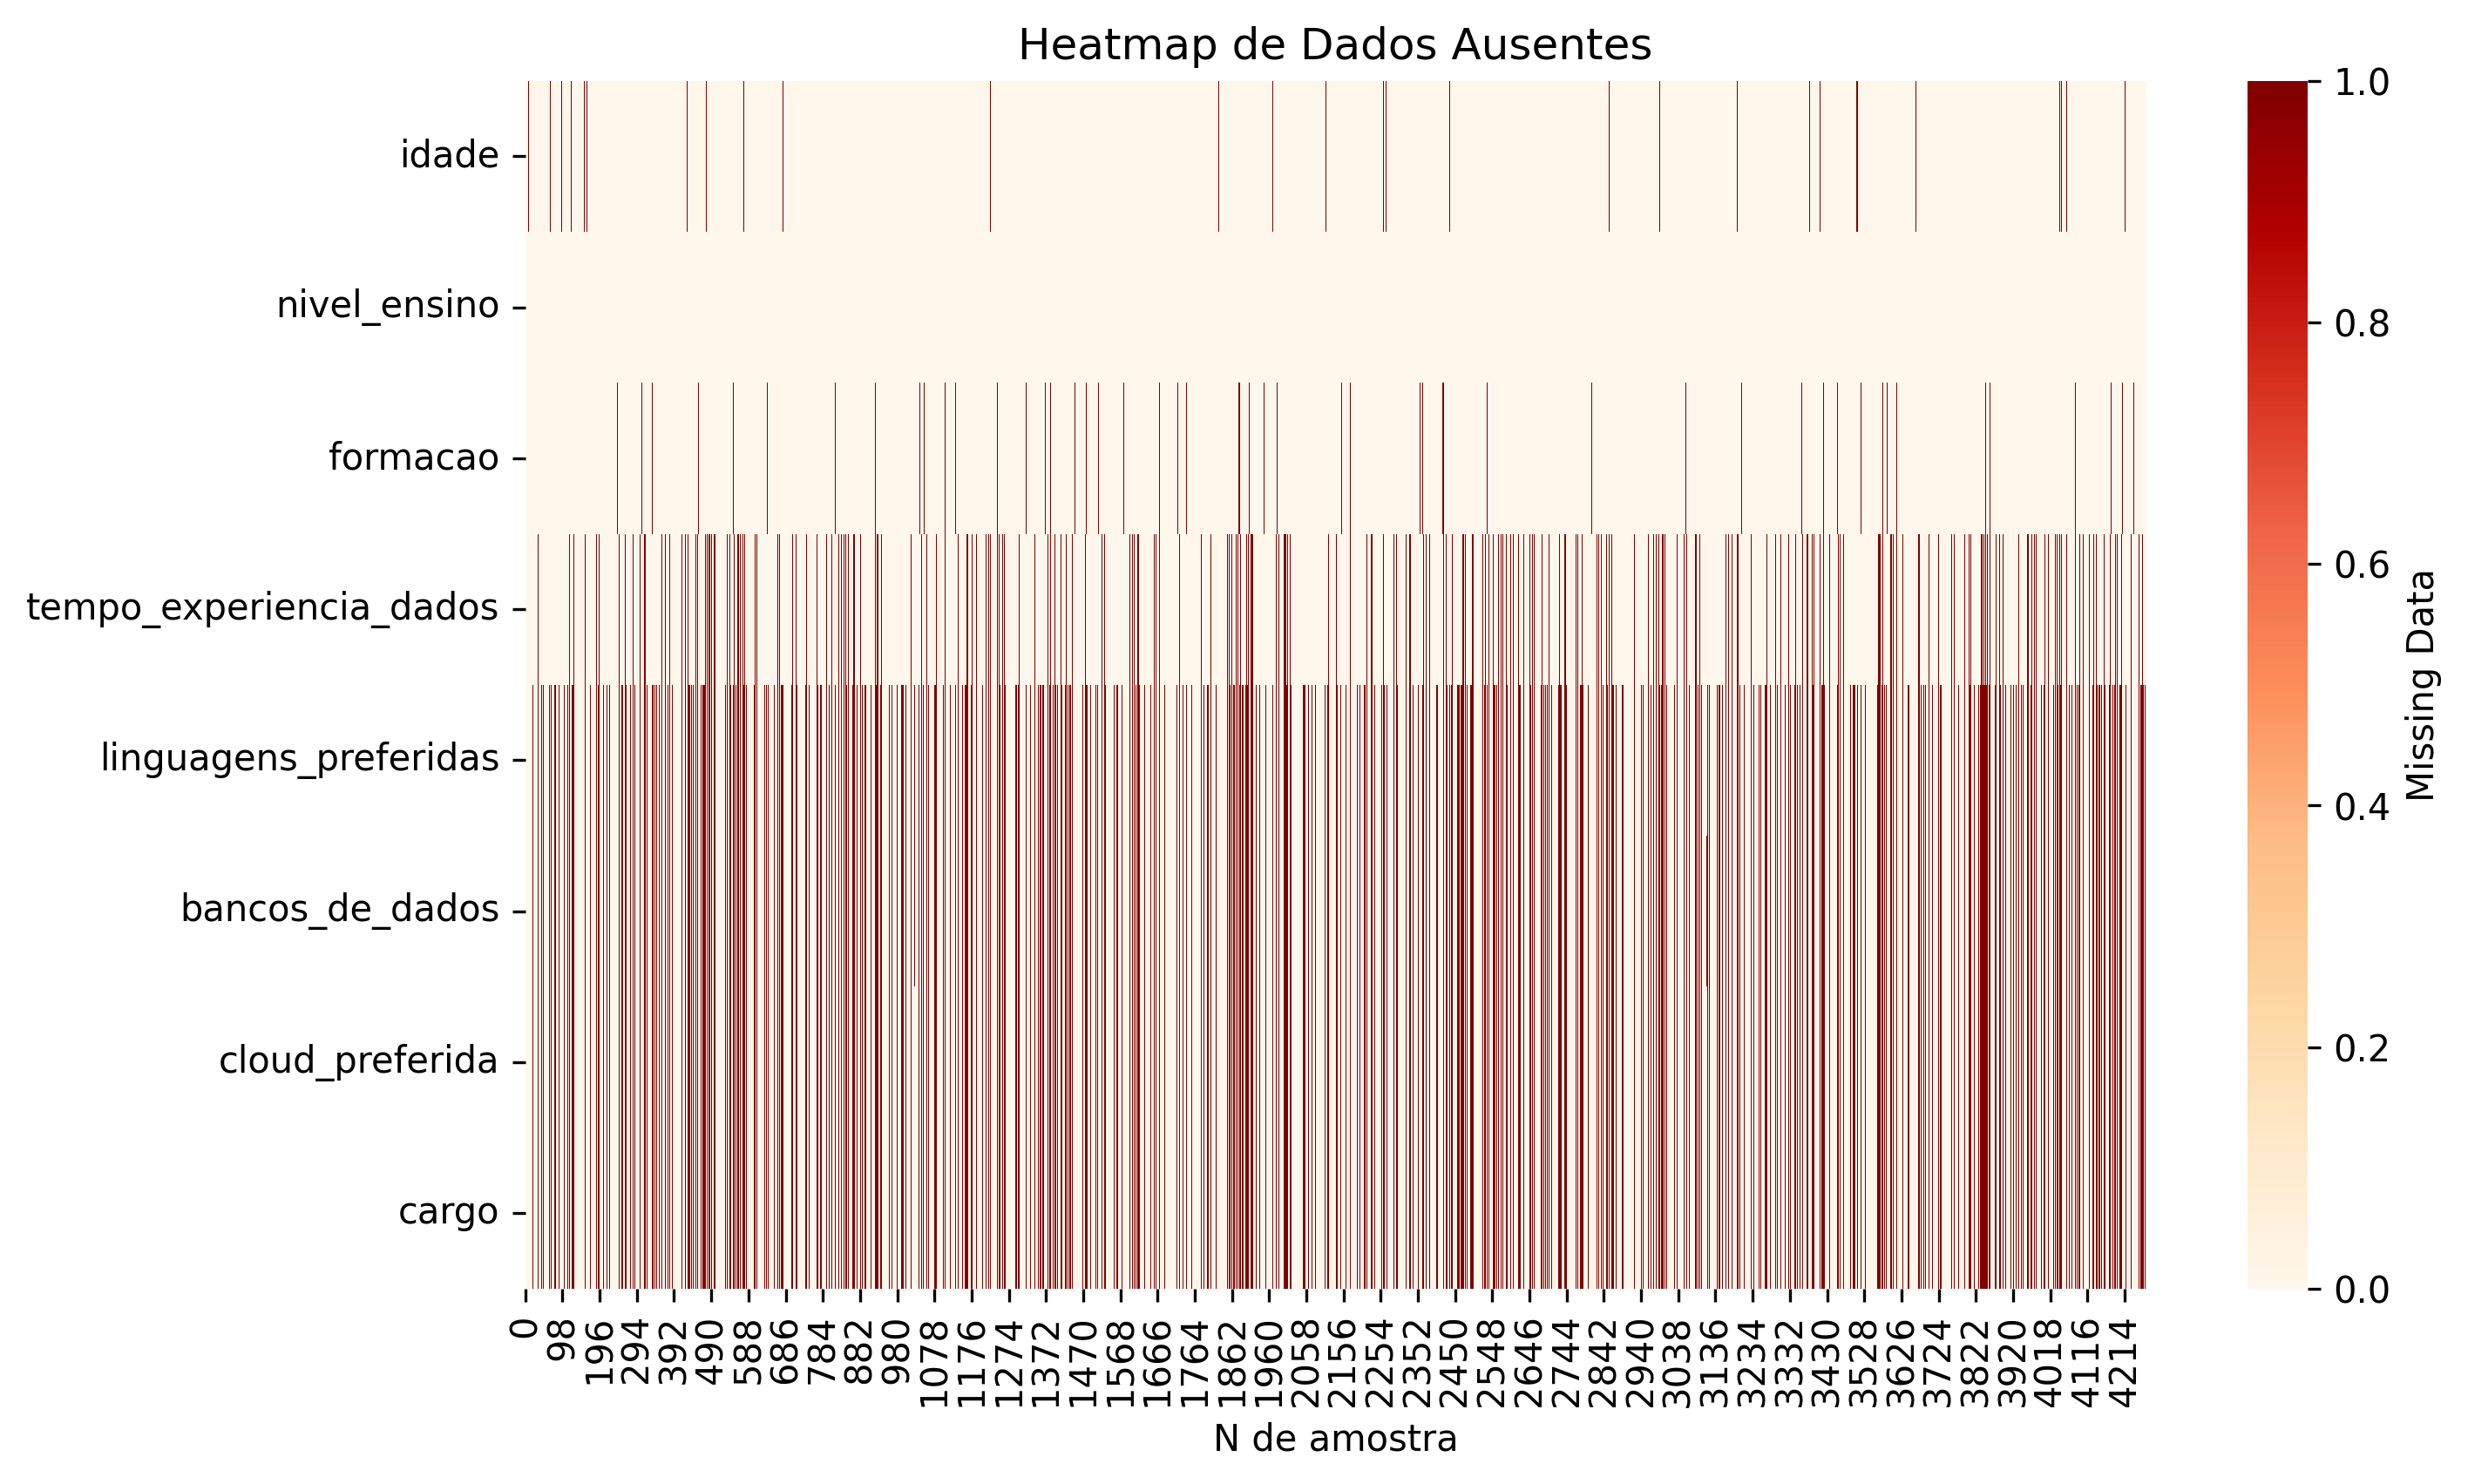

In [ ]:
# Plotar o heatmap
plt.figure(figsize=(10, 6), dpi=300)
sns.heatmap(df_etico_7.isna().transpose(), cmap="OrRd", cbar_kws={'label':'Missing Data'})
plt.title('Heatmap de Dados Ausentes')
plt.xlabel('N de amostra')
plt.show()


Aqui podemos verificar que os dados faltantes em linguagens_preferidas, bancos_de_dados, cloud_preferida e cargo se aproximam bastante, podendo ser das mesmas linhas, inclusive. Para testar isso, vamos "dropar" uma dessas colunas de dados faltantes e verificar como fica a visualização.

In [ ]:
df_etico_8 = df_etico_7.dropna(subset=['linguagens_preferidas'])

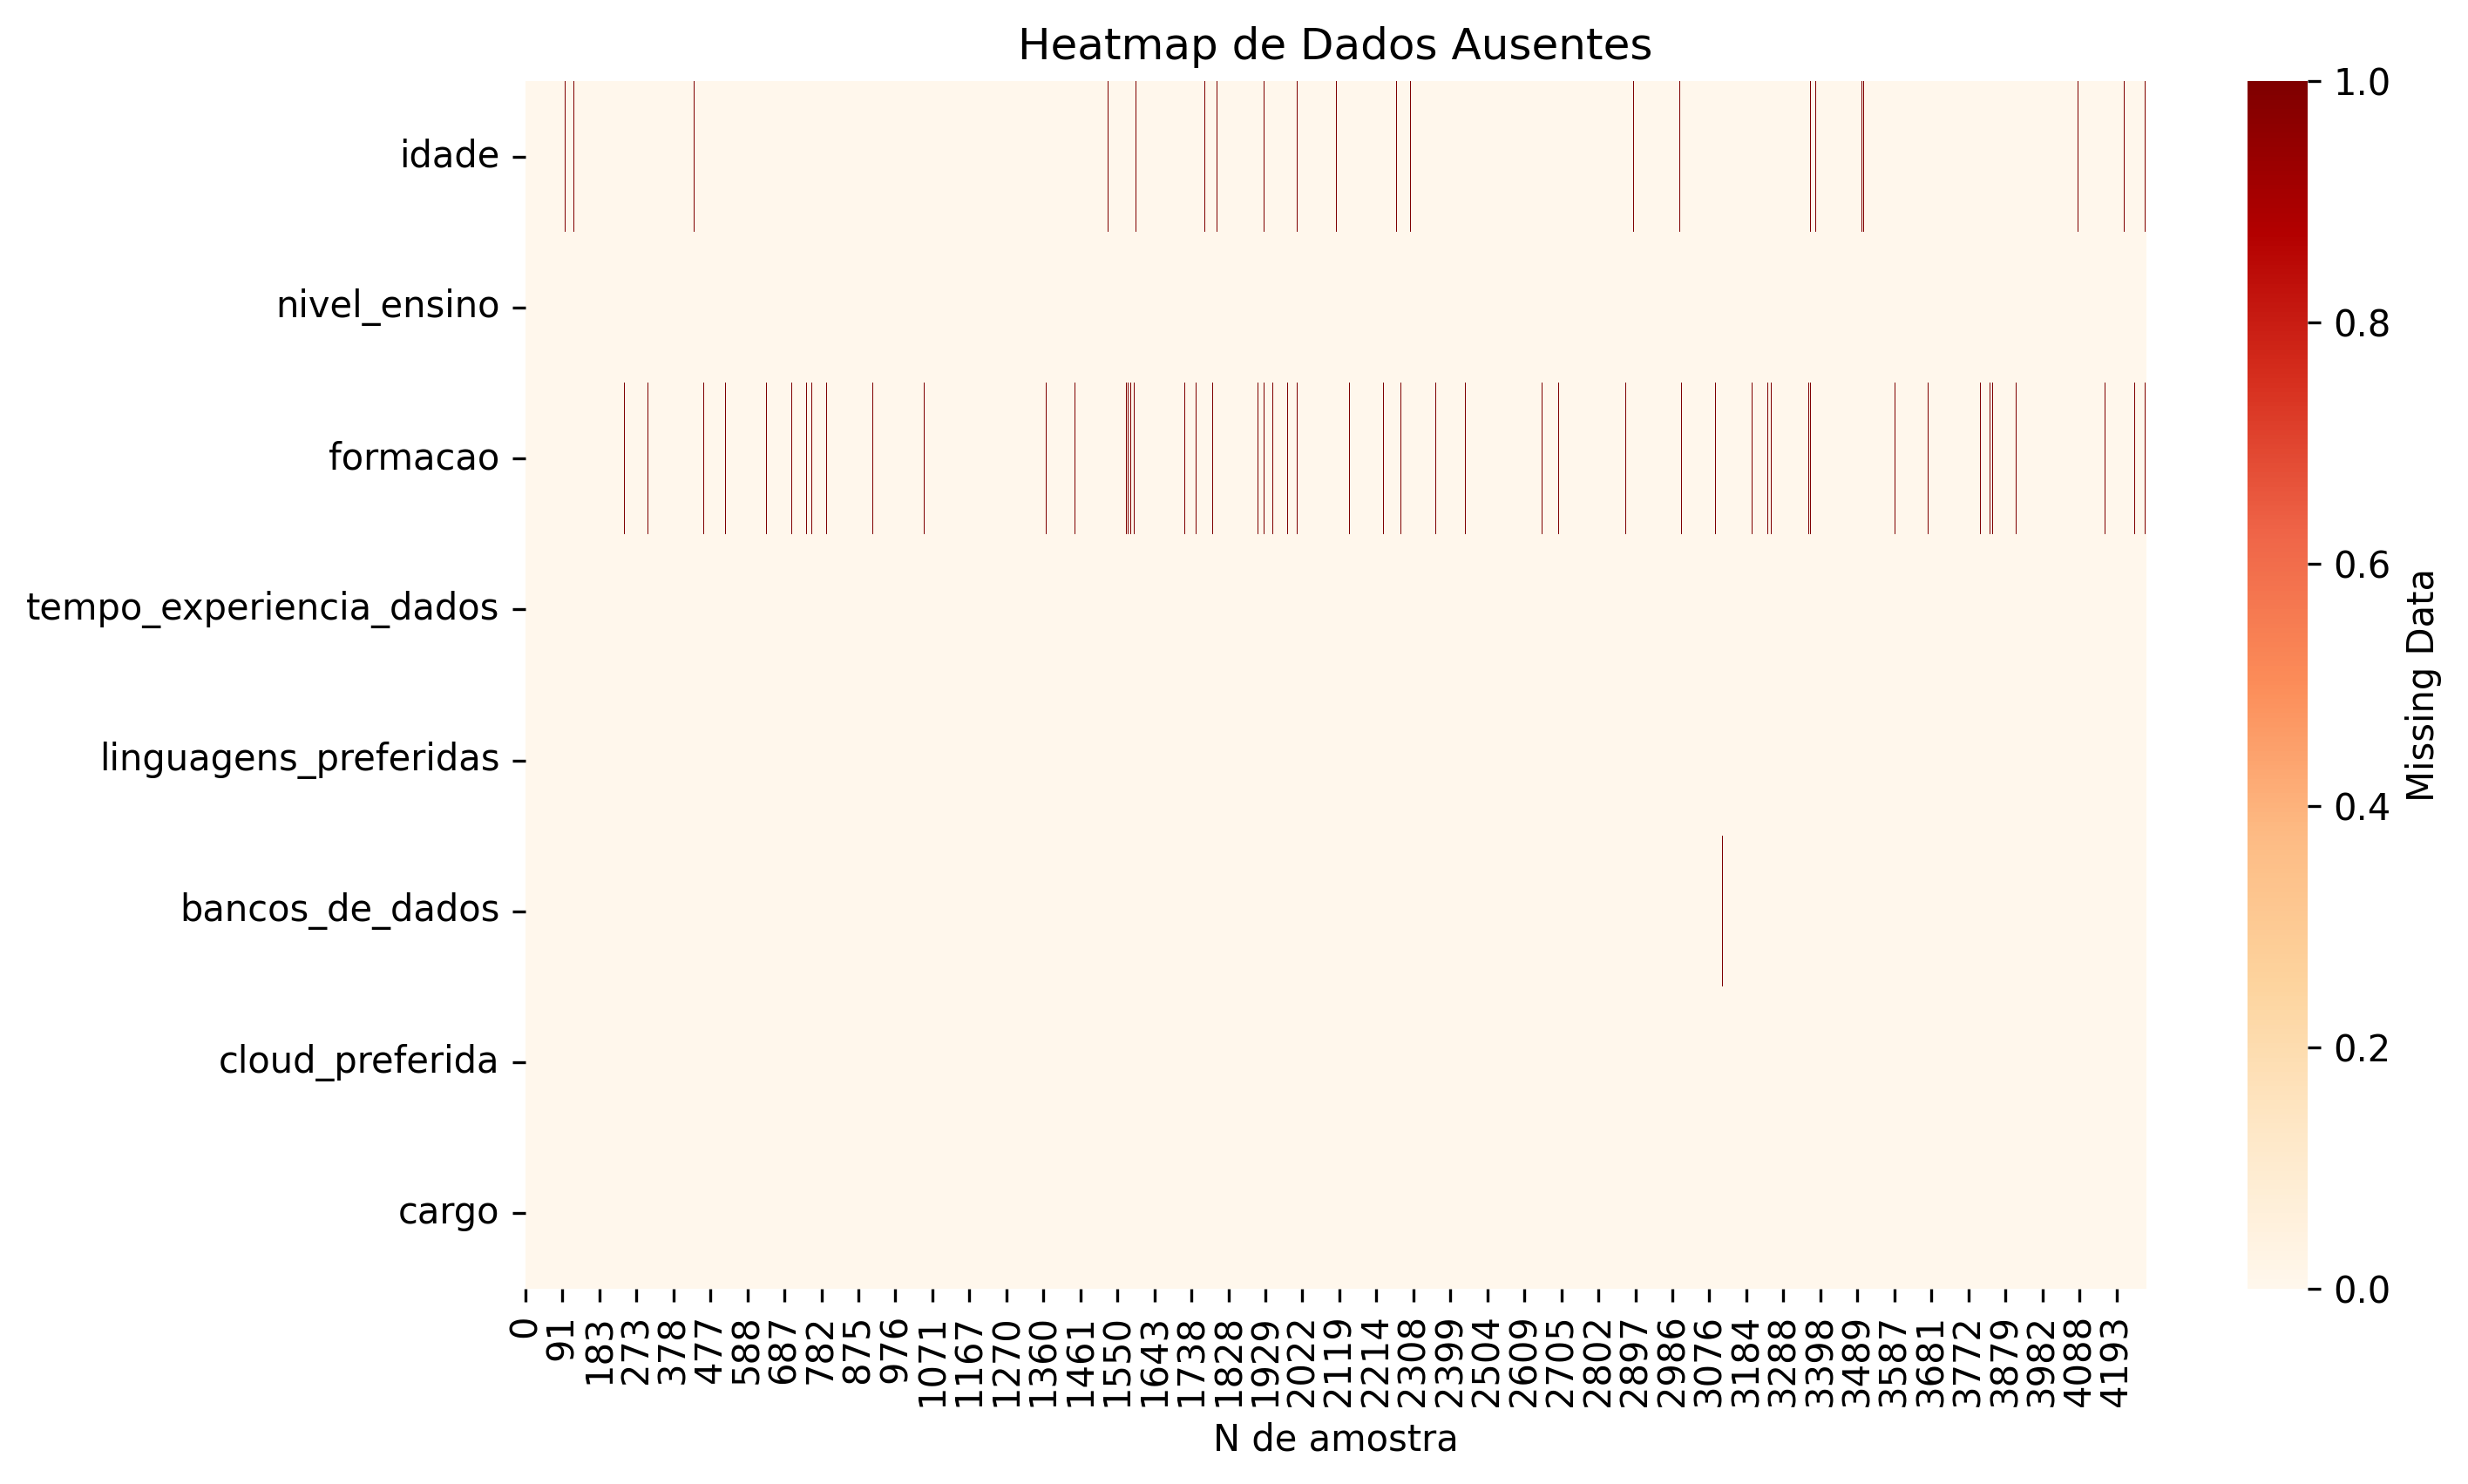

In [ ]:
# Plotar o heatmap
plt.figure(figsize=(10, 6), dpi=300)
sns.heatmap(df_etico_8.isna().transpose(), cmap="OrRd", cbar_kws={'label':'Missing Data'})
plt.title('Heatmap de Dados Ausentes')
plt.xlabel('N de amostra')
plt.show()

De fato, eram as mesmas. Percebemos que esses dados faltantes que removemos não interferiram tanto na qualidade dos dados, já que a maioria da linha estava ausente também.
Iremos remover os demais dados faltantes.

In [ ]:
df_etico_8 = df_etico_8.dropna()

In [ ]:
df_etico_8.isna().sum()

,0
idade,0
nivel_ensino,0
formacao,0
tempo_experiencia_dados,0
linguagens_preferidas,0
bancos_de_dados,0
cloud_preferida,0
cargo,0


## Criação de OHEs

In [ ]:
df_etico_8.columns

Index(['idade', 'nivel_ensino', 'formacao', 'tempo_experiencia_dados',
       'linguagens_preferidas', 'bancos_de_dados', 'cloud_preferida', 'cargo'],
      dtype='object')

In [ ]:
#OHE do nivel de ensino
ohe_nivel_ensino = pd.get_dummies(df_etico_8['nivel_ensino'])
ohe_tempo_experiencia_dados = pd.get_dummies(df_etico_8['tempo_experiencia_dados'])
ohe_formacao = pd.get_dummies(df_etico_8['formacao'])
ohe_linguagens_preferidas = pd.get_dummies(df_etico_8['linguagens_preferidas'])
ohe_cloud_preferida = pd.get_dummies(df_etico_8['cloud_preferida'])
ohe_bancos_de_dados = db_ohe_4.copy()

In [ ]:
ohe_formacao.head()

,Ciências Biológicas/ Farmácia/ Medicina/ Área da Saúde,Ciências Sociais,Computação / Engenharia de Software / Sistemas de Informação/ TI,Economia/ Administração / Contabilidade / Finanças/ Negócios,Estatística/ Matemática / Matemática Computacional/ Ciências Atuariais,Marketing / Publicidade / Comunicação / Jornalismo,Outra formação,Outras Engenharias,Química / Física
0,False,False,True,False,False,False,False,False,False
2,False,False,True,False,False,False,False,False,False
3,False,False,False,False,True,False,False,False,False
4,False,False,True,False,False,False,False,False,False
5,True,False,False,False,False,False,False,False,False
